<a href="https://colab.research.google.com/github/derrickrajkumar10-tech/FUTURE_ML_01/blob/main/notebooks/Sales_Forecasting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing required packages
!pip install prophet pandas matplotlib seaborn plotly scikit-learn openpyxl

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 139.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.3 MB/s eta 0:00:00
✅ All libraries installed successfully!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Sample - Superstore.csv to Sample - Superstore.csv


In [ ]:

df = pd.read_csv('Sample - Superstore.csv', encoding='latin1')

print(df.head())
print(df.info())
print(df.columns)

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

Missing values:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Date range: 1/1/2017 to 9/9/2017

Sales summary:
 count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64


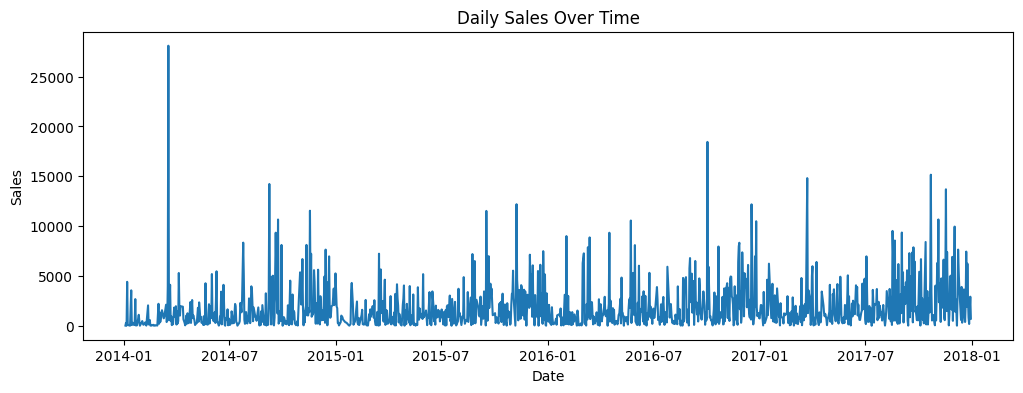

In [ ]:
# EXPLORATORY DATA ANALYSIS
print("Missing values:\n", df.isnull().sum())

# Looking at date column (usually 'Order Date' or 'Date')
print("\nDate range:", df['Order Date'].min(), "to", df['Order Date'].max())

# Checking sales column
print("\nSales summary:\n", df['Sales'].describe())

# Basic visualization
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure(figsize=(12,4))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [ ]:
# 2. MINIMAL PRE-PROCESSING
# Prophet requires a 'ds' column for dates and 'y' for the target value
df['Order Date'] = pd.to_datetime(df['Order Date'])
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

# 3. TRAIN/TEST SPLIT
# Using a standard 80/20 split
split_point = int(len(daily_sales) * 0.8)
train = daily_sales.iloc[:split_point]
test = daily_sales.iloc[split_point:]

# 4. INITIALIZE AND TRAIN MODEL
# No special parameters or holiday additions
model = Prophet()
model.fit(train)

# 5. FORECASTING
# Predicting for the length of the test set
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# 6. EVALUATION
# Comparing the 'yhat' (prediction) to the actual 'y' in the test set
test_results = forecast.set_index('ds').join(test.set_index('ds'), how='inner')
mae = mean_absolute_error(test_results['y'], test_results['yhat'])

print(f"Daily Baseline MAE: ${mae:.2f}")

Daily Baseline MAE: $1646.26


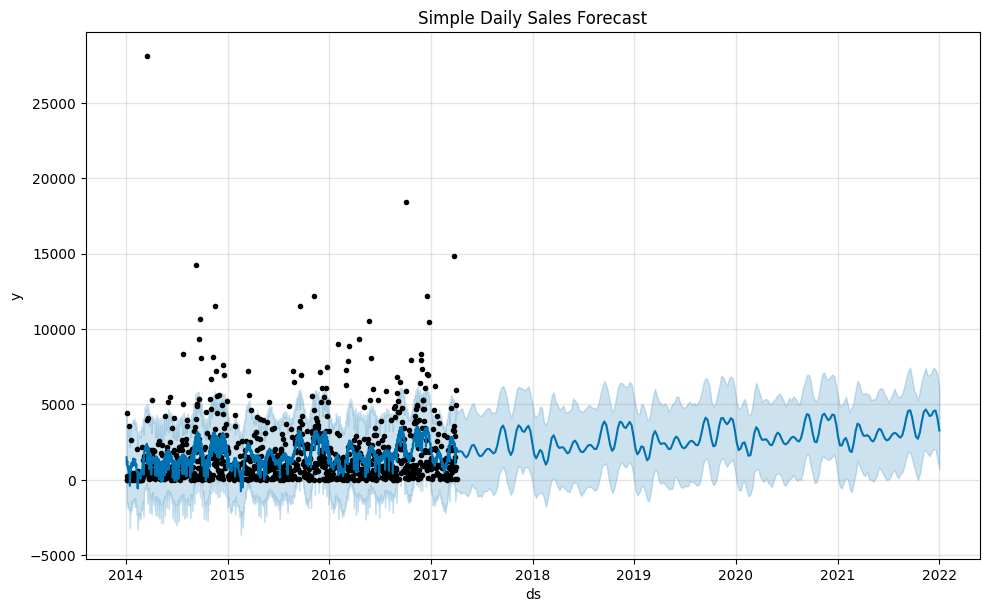

In [ ]:
fig1 = model.plot(forecast)
plt.title("Simple Daily Sales Forecast")
plt.show()

In [ ]:
print("="*80)
print("📦 PREPARING DATA FOR POWER BI")
print("="*80)

# Merge historical data with actuals
historical_export = historical_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
historical_export = historical_export.merge(
    df_prophet.rename(columns={'y': 'Actual_Sales'}),
    left_on='ds',
    right_on='ds',
    how='left'
)
historical_export['Data_Type'] = 'Historical'

# Prepare future forecast
future_export = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
future_export['Actual_Sales'] = None
future_export['Data_Type'] = 'Forecast'

# Combine both
powerbi_data = pd.concat([historical_export, future_export], ignore_index=True)

# Rename columns for clarity
powerbi_data.columns = [
    'Date', 'Forecasted_Sales', 'Lower_Bound', 'Upper_Bound',
    'Trend', 'Actual_Sales', 'Data_Type'
]

# Add useful date features for Power BI filtering
powerbi_data['Year'] = pd.to_datetime(powerbi_data['Date']).dt.year
powerbi_data['Month'] = pd.to_datetime(powerbi_data['Date']).dt.month
powerbi_data['Month_Name'] = pd.to_datetime(powerbi_data['Date']).dt.strftime('%B')
powerbi_data['Quarter'] = pd.to_datetime(powerbi_data['Date']).dt.quarter
powerbi_data['Day_of_Week'] = pd.to_datetime(powerbi_data['Date']).dt.dayofweek
powerbi_data['Day_Name'] = pd.to_datetime(powerbi_data['Date']).dt.day_name()
powerbi_data['Week_of_Year'] = pd.to_datetime(powerbi_data['Date']).dt.isocalendar().week
powerbi_data['Is_Weekend'] = powerbi_data['Day_of_Week'].isin([5, 6]).astype(int)

# Add business-friendly labels
powerbi_data['Quarter_Label'] = 'Q' + powerbi_data['Quarter'].astype(str) + ' ' + powerbi_data['Year'].astype(str)
powerbi_data['Year_Month'] = powerbi_data['Year'].astype(str) + '-' + powerbi_data['Month'].astype(str).str.zfill(2)

# Reorder columns for better readability
column_order = [
    'Date', 'Year', 'Quarter', 'Quarter_Label', 'Month', 'Month_Name', 'Year_Month',
    'Week_of_Year', 'Day_of_Week', 'Day_Name', 'Is_Weekend',
    'Data_Type', 'Actual_Sales', 'Forecasted_Sales', 'Lower_Bound', 'Upper_Bound', 'Trend'
]
powerbi_data = powerbi_data[column_order]

print(f"\n✅ Power BI dataset created!")
print(f"   Total records: {len(powerbi_data)}")
print(f"   Historical records: {len(powerbi_data[powerbi_data['Data_Type']=='Historical'])}")
print(f"   Forecast records: {len(powerbi_data[powerbi_data['Data_Type']=='Forecast'])}")
print(f"   Date range: {powerbi_data['Date'].min()} to {powerbi_data['Date'].max()}")
print(f"   Columns: {len(powerbi_data.columns)}")

print(f"\n📋 Column list:")
for i, col in enumerate(powerbi_data.columns, 1):
    print(f"   {i}. {col}")

print(f"\n📊 Sample data (first 5 rows):")
print(powerbi_data.head())

print(f"\n📊 Sample data (last 5 rows - future forecast):")
print(powerbi_data.tail())

# Save to CSV
powerbi_data.to_csv('sales_forecast_powerbi.csv', index=False)
print(f"\n✅ Saved: sales_forecast_powerbi.csv")